A notebook for verifying the statistics computed for grouped regression, when we are testing to see if one coefficient is different than the average of the rest. 

Here we consider the setting where we have $S$ subjects and $N_s$ samples from each subject pulled from a model with the following form: 

$y_{i,s} = c'x_{i,s} + u_i + \epsilon_{x},$

where $y_{i,s}$ is the $i^{th}$ observation for subject $s$, $x_{i,s}$ is a one-hot vector encoding input, $u_i \sim \mathcal{N}(0, \phi)$ is a subject-specific error term and $\epsilon_i{x} \sim \mathcal{N}(0, \sigma^2_{{x_{i,s}}})$ is a 
noise term that depends on $x_{i,s}$ (there is a different noise standard deviation depending on the column of x that is active). Intuitively, this is a model where observations take on the mean value of a variable (the coefficents in $c$, depending on which variable is active) and there is also subject-specific offsets that get assigned to the observation. 

The goal of this script is to generate data from this type of model many times, always keeping $c$ fixed.  We then test to see if each entry in c is different from the mean of the other coefficients. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from janelia_core.stats.regression import grouped_linear_regression_ols_estimator
from janelia_core.stats.regression import grouped_linear_regression_acm_stats

from keller_zlatic_vnc.whole_brain.whole_brain_stat_functions import test_for_different_than_avg_beta

# Parameters go here

In [3]:
coefs = np.asarray([-2.0, 1.0, -0.5]) # List average actual values for each variable

coef_stds = np.asarray([.1, .1, .1]) # List standard deviation of noise associated with observation for each variable

corr_err_std = 2.0 # Standard deviation of error that is added to each subject's values 

n_smps_per_subj = [10, 15] # Range of the number of samples we can observe per subject

n_subjs = 100 # Number of subjects we simulate data from 

n_sims = 1000 # Number of simulations we run to get distributions of p-values

## Define some helper functions 

In [4]:
def gen_subj_data():
    
    n_coefs = len(coefs)
    n_smps = np.random.randint(n_smps_per_subj[0], n_smps_per_subj[1] + 1)
    
    y = np.zeros(n_smps)
    x = np.zeros([n_smps, n_coefs])
    
    for s_i in range(n_smps):
        coef_i = np.random.randint(0, n_coefs)
        y[s_i] = coef_stds[coef_i]*np.random.randn() + coefs[coef_i]
        x[s_i, coef_i] = 1
        
    y = y + corr_err_std*np.random.randn()
        
    return y, x

def gen_data():
    y = list()
    x = list()
    g = list()
    for subj_i in range(n_subjs):
        y_i, x_i = gen_subj_data()
        g_i = subj_i*np.ones_like(y_i)
        y.append(y_i)
        x.append(x_i)
        g.append(g_i)
        
    y = np.concatenate(y, axis=0)
    x = np.concatenate(x, axis=0)
    g = np.concatenate(g, axis=0)
    
    return y, x, g

## Do a whole bunch of simulations and get distribution of p-values for each coefficient

In [5]:
n_coefs = len(coefs)
p_vls = np.zeros([n_sims,  n_coefs])
for sim_i in range(n_sims):
    y_i, x_i, g_i = gen_data()
    beta, acm, n_grps = grouped_linear_regression_ols_estimator(x=x_i, y=y_i, g=g_i)
    p_vls[sim_i,:], _ = test_for_different_than_avg_beta(beta=beta, acm=acm, n_grps=n_grps, alpha=.05)

## Now look at our performance

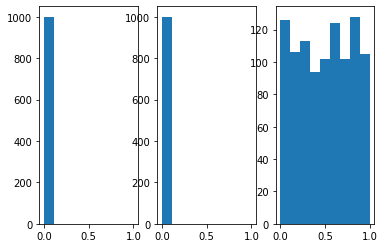

In [6]:
plt.figure()
for c_i in range(3):
    plt.subplot(1,3,c_i+1)
    plt.hist(p_vls[:,c_i], bins=np.linspace(0, 1, 10))